Ejecutando optimización Monte Carlo...
Simulación 1000/5000 completada
Simulación 2000/5000 completada
Simulación 3000/5000 completada
Simulación 4000/5000 completada
Simulación 5000/5000 completada

Optimización completada!
Mejor valor objetivo: 1.0836
Mejores escalares: [0.01124992 0.00279646 0.98595362]


C:\Users\Zkorpion\AppData\Local\Temp\ipykernel_14436\1391136813.py:255: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(scalars_matrix, labels=scalar_labels)


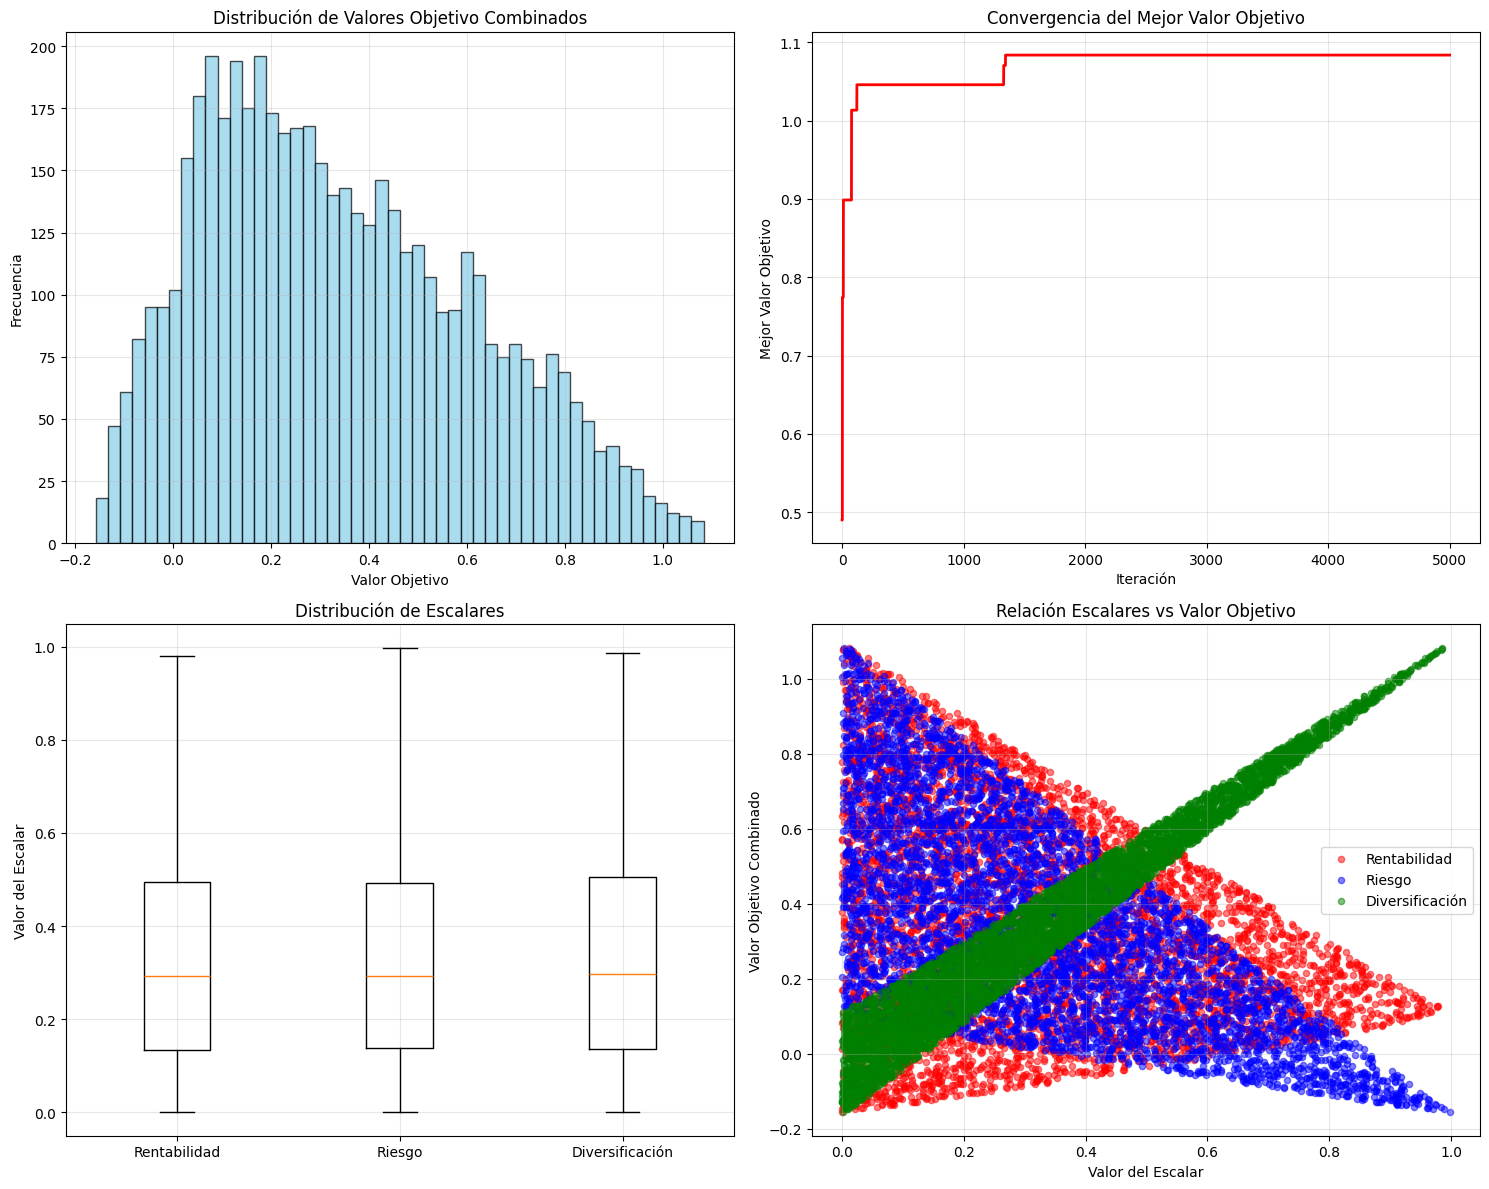


ESTADÍSTICAS DESCRIPTIVAS

MEJOR RESULTADO:
Valor objetivo combinado: 1.0836
Escalares óptimos:
  - Rentabilidad: 0.0112
  - Riesgo: 0.0028
  - Diversificación: 0.9860

Objetivos individuales:
  - Rentabilidad: 0.0903
  - Riesgo (negativo): -0.2055
  - Diversificación: 1.0986

Pesos del portafolio óptimo:
  - Activo 1: 0.1672
  - Activo 2: 0.1665
  - Activo 3: 0.1662
  - Activo 4: 0.1670
  - Activo 5: 0.3331

ESTADÍSTICAS GENERALES:
Valor objetivo promedio: 0.3410
Desviación estándar: 0.2729
Rango: [-0.1567, 1.0836]

RESUMEN FINAL:
Los escalares óptimos encontrados son:
- Rentabilidad: 0.011
- Riesgo: 0.003
- Diversificación: 0.986
Valor objetivo máximo: 1.0836


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Callable
from dataclasses import dataclass
import random
from scipy.optimize import minimize
import seaborn as sns

@dataclass
class OptimizationResult:
  """Clase para almacenar resultados de optimización"""
  scalars: np.ndarray
  objective_values: np.ndarray
  combined_value: float
  portfolio_weights: np.ndarray

class MultiObjectiveOptimizer:
  """
  Optimizador multi-objetivo usando método de Monte Carlo
  para selección de escalares en combinación lineal
  """
  
  def __init__(self, num_assets: int = 5, num_simulations: int = 10000):
    """
    Inicializa el optimizador
    
    Args:
      num_assets: Número de activos en el portafolio
      num_simulations: Número de simulaciones Monte Carlo
    """
    self.num_assets: int = num_assets
    self.num_simulations: int = num_simulations
    self.num_objectives: int = 3  # Rentabilidad, Riesgo, Diversificación
    
    # Generar datos sintéticos del mercado
    self._generate_market_data()
    
    # Almacenar resultados
    self.results: List[OptimizationResult] = []
    
  def _generate_market_data(self) -> None:
    """Genera datos sintéticos del mercado financiero"""
    np.random.seed(42)  # Para reproducibilidad
    
    # Retornos esperados (%)
    self.expected_returns: np.ndarray = np.random.normal(0.08, 0.03, self.num_assets)
    
    # Matriz de covarianza (riesgo)
    correlation_matrix: np.ndarray = np.random.rand(self.num_assets, self.num_assets)
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1.0)
    
    volatilities: np.ndarray = np.random.uniform(0.15, 0.35, self.num_assets)
    self.covariance_matrix: np.ndarray = np.outer(volatilities, volatilities) * correlation_matrix
    
    # Sectores para diversificación (0=Tech, 1=Finance, 2=Healthcare, etc.)
    self.sectors: np.ndarray = np.random.randint(0, 3, self.num_assets)
    
  def objective_1_profitability(self, weights: np.ndarray) -> float:
    """
    Objetivo 1: Maximizar rentabilidad esperada
    
    Args:
      weights: Pesos del portafolio
      
    Returns:
      Rentabilidad esperada del portafolio
    """
    return np.dot(weights, self.expected_returns)
    
  def objective_2_risk(self, weights: np.ndarray) -> float:
    """
    Objetivo 2: Minimizar riesgo (maximizar -riesgo)
    
    Args:
      weights: Pesos del portafolio
      
    Returns:
      Negativo de la volatilidad del portafolio
    """
    portfolio_variance: float = np.dot(weights, np.dot(self.covariance_matrix, weights))
    return -np.sqrt(portfolio_variance)  # Negativo para maximizar
    
  def objective_3_diversification(self, weights: np.ndarray) -> float:
    """
    Objetivo 3: Maximizar diversificación sectorial
    
    Args:
      weights: Pesos del portafolio
      
    Returns:
      Índice de diversificación (entropía)
    """
    # Calcular peso por sector
    sector_weights: Dict[int, float] = {}
    for i, sector in enumerate(self.sectors):
      sector_weights[sector] = sector_weights.get(sector, 0) + weights[i]
    
    # Calcular entropía (mayor entropía = mayor diversificación)
    entropy: float = 0.0
    for weight in sector_weights.values():
      if weight > 0:
        entropy -= weight * np.log(weight)
    
    return entropy
    
  def evaluate_objectives(self, weights: np.ndarray) -> np.ndarray:
    """
    Evalúa todos los objetivos para un portafolio dado
    
    Args:
      weights: Pesos del portafolio
      
    Returns:
      Array con valores de los tres objetivos
    """
    obj1: float = self.objective_1_profitability(weights)
    obj2: float = self.objective_2_risk(weights)
    obj3: float = self.objective_3_diversification(weights)
    
    return np.array([obj1, obj2, obj3])
    
  def combined_objective(self, weights: np.ndarray, scalars: np.ndarray) -> float:
    """
    Función objetivo combinada usando escalares
    
    Args:
      weights: Pesos del portafolio
      scalars: Escalares para combinar objetivos
      
    Returns:
      Valor de la función objetivo combinada
    """
    objectives: np.ndarray = self.evaluate_objectives(weights)
    return np.dot(scalars, objectives)
    
  def optimize_portfolio(self, scalars: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Optimiza el portafolio para escalares dados
    
    Args:
      scalars: Escalares para los objetivos
      
    Returns:
      Tupla con pesos óptimos y valor objetivo
    """
    # Restricciones: suma de pesos = 1, pesos >= 0
    constraints: List[Dict] = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
    bounds: List[Tuple[float, float]] = [(0.0, 1.0) for _ in range(self.num_assets)]
    
    # Peso inicial uniforme
    initial_weights: np.ndarray = np.ones(self.num_assets) / self.num_assets
    
    # Optimizar (minimizar el negativo para maximizar)
    result = minimize(
      fun=lambda w: -self.combined_objective(w, scalars),
      x0=initial_weights,
      method='SLSQP',
      bounds=bounds,
      constraints=constraints
    )
    
    return result.x, -result.fun
    
  def generate_random_scalars(self) -> np.ndarray:
    """
    Genera escalares aleatorios que suman 1
    
    Returns:
      Array de escalares normalizados
    """
    # Generar valores aleatorios positivos
    raw_scalars: np.ndarray = np.random.exponential(1.0, self.num_objectives)
    
    # Normalizar para que sumen 1
    return raw_scalars / np.sum(raw_scalars)
    
  def run_monte_carlo_optimization(self) -> None:
    """Ejecuta la optimización Monte Carlo"""
    print("Ejecutando optimización Monte Carlo...")
    
    self.results = []
    best_value: float = -np.inf
    best_scalars: np.ndarray = None
    
    for i in range(self.num_simulations):
      # Generar escalares aleatorios
      scalars: np.ndarray = self.generate_random_scalars()
      
      # Optimizar portafolio con estos escalares
      optimal_weights, objective_value = self.optimize_portfolio(scalars)
      
      # Evaluar objetivos individuales
      individual_objectives: np.ndarray = self.evaluate_objectives(optimal_weights)
      
      # Almacenar resultado
      result = OptimizationResult(
        scalars=scalars,
        objective_values=individual_objectives,
        combined_value=objective_value,
        portfolio_weights=optimal_weights
      )
      self.results.append(result)
      
      # Actualizar mejor resultado
      if objective_value > best_value:
        best_value = objective_value
        best_scalars = scalars.copy()
      
      # Mostrar progreso
      if (i + 1) % 1000 == 0:
        print(f"Simulación {i + 1}/{self.num_simulations} completada")
    
    print(f"\nOptimización completada!")
    print(f"Mejor valor objetivo: {best_value:.4f}")
    print(f"Mejores escalares: {best_scalars}")
    
  def analyze_results(self) -> None:
    """Analiza y visualiza los resultados"""
    if not self.results:
      print("No hay resultados para analizar. Ejecute run_monte_carlo_optimization() primero.")
      return
    
    # Extraer datos para análisis
    combined_values: np.ndarray = np.array([r.combined_value for r in self.results])
    scalars_matrix: np.ndarray = np.array([r.scalars for r in self.results])
    objectives_matrix: np.ndarray = np.array([r.objective_values for r in self.results])
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histograma de valores objetivo combinados
    axes[0, 0].hist(combined_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribución de Valores Objetivo Combinados')
    axes[0, 0].set_xlabel('Valor Objetivo')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Convergencia del mejor valor
    best_values: List[float] = []
    current_best: float = -np.inf
    for value in combined_values:
      if value > current_best:
        current_best = value
      best_values.append(current_best)
    
    axes[0, 1].plot(best_values, color='red', linewidth=2)
    axes[0, 1].set_title('Convergencia del Mejor Valor Objetivo')
    axes[0, 1].set_xlabel('Iteración')
    axes[0, 1].set_ylabel('Mejor Valor Objetivo')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Distribución de escalares
    scalar_labels: List[str] = ['Rentabilidad', 'Riesgo', 'Diversificación']
    axes[1, 0].boxplot(scalars_matrix, labels=scalar_labels)
    axes[1, 0].set_title('Distribución de Escalares')
    axes[1, 0].set_ylabel('Valor del Escalar')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Correlación entre escalares y valor objetivo
    colors: List[str] = ['red', 'blue', 'green']
    for i, label in enumerate(scalar_labels):
      axes[1, 1].scatter(scalars_matrix[:, i], combined_values, 
                        alpha=0.5, color=colors[i], label=label, s=20)
    
    axes[1, 1].set_title('Relación Escalares vs Valor Objetivo')
    axes[1, 1].set_xlabel('Valor del Escalar')
    axes[1, 1].set_ylabel('Valor Objetivo Combinado')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas descriptivas
    self._print_statistics(combined_values, scalars_matrix, objectives_matrix)
    
  def _print_statistics(self, combined_values: np.ndarray, 
                       scalars_matrix: np.ndarray, 
                       objectives_matrix: np.ndarray) -> None:
    """Imprime estadísticas descriptivas"""
    print("\n" + "="*50)
    print("ESTADÍSTICAS DESCRIPTIVAS")
    print("="*50)
    
    # Mejor resultado
    best_idx: int = np.argmax(combined_values)
    best_result: OptimizationResult = self.results[best_idx]
    
    print(f"\nMEJOR RESULTADO:")
    print(f"Valor objetivo combinado: {best_result.combined_value:.4f}")
    print(f"Escalares óptimos:")
    scalar_names: List[str] = ['  - Rentabilidad', '  - Riesgo', '  - Diversificación']
    for i, name in enumerate(scalar_names):
      print(f"{name}: {best_result.scalars[i]:.4f}")
    
    print(f"\nObjetivos individuales:")
    obj_names: List[str] = ['  - Rentabilidad', '  - Riesgo (negativo)', '  - Diversificación']
    for i, name in enumerate(obj_names):
      print(f"{name}: {best_result.objective_values[i]:.4f}")
    
    print(f"\nPesos del portafolio óptimo:")
    for i, weight in enumerate(best_result.portfolio_weights):
      print(f"  - Activo {i+1}: {weight:.4f}")
    
    # Estadísticas generales
    print(f"\nESTADÍSTICAS GENERALES:")
    print(f"Valor objetivo promedio: {np.mean(combined_values):.4f}")
    print(f"Desviación estándar: {np.std(combined_values):.4f}")
    print(f"Rango: [{np.min(combined_values):.4f}, {np.max(combined_values):.4f}]")
    
  def get_best_result(self) -> OptimizationResult:
    """Retorna el mejor resultado encontrado"""
    if not self.results:
      raise ValueError("No hay resultados disponibles")
    
    best_idx: int = np.argmax([r.combined_value for r in self.results])
    return self.results[best_idx]

# Ejemplo de uso
if __name__ == "__main__":
  # Crear optimizador
  optimizer = MultiObjectiveOptimizer(num_assets=5, num_simulations=5000)
  
  # Ejecutar optimización Monte Carlo
  optimizer.run_monte_carlo_optimization()
  
  # Analizar resultados
  optimizer.analyze_results()
  
  # Obtener mejor resultado
  best_result = optimizer.get_best_result()
  
  print(f"\nRESUMEN FINAL:")
  print(f"Los escalares óptimos encontrados son:")
  print(f"- Rentabilidad: {best_result.scalars[0]:.3f}")
  print(f"- Riesgo: {best_result.scalars[1]:.3f}")
  print(f"- Diversificación: {best_result.scalars[2]:.3f}")
  print(f"Valor objetivo máximo: {best_result.combined_value:.4f}")